#### Observations
- single plant ve multi plantte aynı model kurunca number of parameters değişmiyor, yani multi plantte her planti aynı weightlerle çarpıyor, bunun sonucu olarak da single plantte gelen wmapeler multi de gelemiyor, dense case'i için, CNN performansı fena değil
- convolution hem 1 plantte hem multiple plantte çalışabiliyor, biz 5 kernel size tanımlarken nasıl tek plantte çalışabiliyor bunu iyi anla


- 749 0,1,2 sadece üretim Çeşme ARES sondan 2
- 1524 artıyor  
- 2104 son yarıda kötü sondan 3
- 2235 son yarı bok
- 2326 sonlarda bi kötü


son 20
[2058,
 2031,
 2040,
 1194,
 2089,
 2050,
 1883,
 2235,
 1524,
 1939,
 1493,
 2291,
 1485,
 1503,
 1488,
 1943,
 1843,
 2104,
 749,
 1655]

```
import pandas as pd
ege = pd.read_csv("../../data/meta/ege_farms.csv")
vals = [749, 1524, 2104, 2235, 2326]
ege[ege["rt_plant_id"].isin(vals)]
```

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import subprocess; FOLDER_PATH = subprocess.Popen(['git', 'rev-parse', '--show-toplevel'], stdout=subprocess.PIPE).communicate()[0].rstrip().decode('utf-8')
import warnings; warnings.filterwarnings("ignore")
import sys, os; sys.path.append(os.path.dirname(f'{FOLDER_PATH}/utils')); sys.path.append(os.path.dirname(f'{FOLDER_PATH}/scripts'))

In [3]:
import wandb

In [4]:
from utils.base_helpers import DataReader
from utils.tf_helpers import WindowGenerator, BaseTFModel
import tensorflow as tf
from tensorflow.keras import models, layers

2022-05-22 15:31:39.674423: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-22 15:31:39.674487: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-05-22 15:31:46.114951: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-22 15:31:46.115043: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (algopoly): /proc/driver/nvidia/version does not exist


In [5]:
config={
    "window": {
        "label_width": 24,
        "input_width": 48,
        "shift": 0,
    },
    "compiler":{
        "patience": 3,
        "epochs": 10,
        "optimizer": "adam",
        "loss": "mse",
        "verbose": 1,
    }
}

In [6]:
data = DataReader(number_of_plants=94)
data.process(train_ratio=0.64295, valid_ratio=0.082, test_ratio=0.08288, corr_order=True)


Train start and end dates:	 2019-01-26 03:00:00 	 2020-12-31 23:00:00
Validation start and end dates:	 2021-01-01 00:00:00 	 2021-03-31 23:00:00
Test start and end dates:	 2021-04-01 00:00:00 	 2021-06-30 23:00:00


In [7]:
data.plants

[1472,
 1944,
 2374,
 1929,
 1900,
 2184,
 2089,
 2113,
 1459,
 2031,
 2224,
 1460,
 2288,
 1977,
 1959,
 1502,
 1494,
 2058,
 1499,
 1485,
 1505,
 1501,
 2050,
 2063,
 1899,
 2083,
 2112,
 2073,
 1759,
 2116,
 2062,
 2070,
 2040,
 968,
 2125,
 1737,
 2323,
 2123,
 2180,
 969,
 1527,
 1528,
 1525,
 1709,
 1741,
 1523,
 1484,
 1504,
 1506,
 2140,
 1514,
 1509,
 1518,
 1511,
 1761,
 1883,
 1507,
 757,
 1512,
 1928,
 1498,
 1488,
 1781,
 2166,
 1843,
 1487,
 1489,
 1493,
 1490,
 1878,
 1508,
 672,
 1516,
 1519,
 1537,
 1517,
 2114,
 2291,
 1492,
 1491,
 1503,
 1194,
 1945,
 1655,
 1513,
 1524,
 1943,
 1578,
 2326,
 1939]

In [54]:
corr

rt_plant_id,672,749,757,968,969,1194,1459,1460,1472,1484,...,2166,2180,2184,2224,2235,2288,2291,2323,2326,2374
rt_plant_id,,,,,,,,,,,,,,,,,,,,,
672,1.000000,0.324449,0.817973,0.554499,0.698249,0.720920,0.184727,0.071510,0.222975,0.590950,...,0.580342,0.647567,0.302292,0.123439,0.134409,0.043979,0.820397,0.555049,0.526201,0.252218
749,0.324449,1.000000,0.374205,0.451927,0.454317,0.238736,0.308774,0.241451,0.379332,0.374879,...,0.383271,0.466533,0.398528,0.293088,0.278143,0.174591,0.376005,0.371240,0.368333,0.397802
757,0.817973,0.374205,1.000000,0.625863,0.733005,0.666141,0.253865,0.070016,0.275623,0.544299,...,0.578169,0.661906,0.416457,0.191599,0.165682,0.001816,0.782212,0.617422,0.612713,0.328275
968,0.554499,0.451927,0.625863,1.000000,0.760748,0.494065,0.410234,0.217210,0.478832,0.686848,...,0.779239,0.738222,0.493154,0.323418,0.265256,0.177163,0.538343,0.795753,0.661056,0.554629
969,0.698249,0.454317,0.733005,0.760748,1.000000,0.536955,0.394008,0.262015,0.485543,0.839968,...,0.758613,0.889300,0.457165,0.279588,0.290975,0.258444,0.685080,0.727224,0.701866,0.467211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,0.043979,0.174591,0.001816,0.177163,0.258444,-0.069161,0.317288,0.816462,0.503851,0.315074,...,0.224364,0.275711,0.230784,0.550736,0.622811,1.000000,0.079187,0.140452,0.166582,0.332021
2291,0.820397,0.376005,0.782212,0.538343,0.685080,0.688563,0.191790,0.092237,0.246973,0.576684,...,0.583713,0.664642,0.332359,0.126947,0.173592,0.079187,1.000000,0.528211,0.532772,0.275716
2323,0.555049,0.371240,0.617422,0.795753,0.727224,0.450183,0.416569,0.173870,0.468765,0.704633,...,0.743824,0.750960,0.499028,0.294227,0.237224,0.140452,0.528211,1.000000,0.786611,0.485743


In [ ]:
plants = self.plants.copy()
corr = pd.pivot_table(
    self.raw_df[["rt_plant_id", "production", "forecast_dt"]],
    index="forecast_dt", columns="rt_plant_id",
    values="production").corr()

In [64]:
import numpy as np

In [6]:
data = DataReader(number_of_plants=94)
# data.process(train_ratio=0.9, valid_ratio=0.001)

# 2021-01/2021-03
# data.process(train_ratio=0.56098, valid_ratio=0.082, test_ratio=0.08197)

# 2021-03/2021-06
data.process(train_ratio=0.64295, valid_ratio=0.082, test_ratio=0.08288)

# 2021-06/2021-09
# data.process(train_ratio=0.72495, valid_ratio=0.08288, test_ratio=0.0838)

# 2021-10/2021-12
# data.process(train_ratio=0.80783, valid_ratio=0.0838, test_ratio=0.0838)

Train start and end dates:	 2019-01-26 03:00:00 	 2020-12-31 23:00:00
Validation start and end dates:	 2021-01-01 00:00:00 	 2021-03-31 23:00:00
Test start and end dates:	 2021-04-01 00:00:00 	 2021-06-30 23:00:00


In [15]:
window = WindowGenerator(data=data, **config["window"])
window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['production']

In [16]:
class Linear2(BaseTFModel):
    def add_model(self, model):
        model.add(layers.Dense(48, kernel_initializer=tf.initializers.zeros()))
        model.add(layers.Dropout(0.2))
        model.add(layers.Permute((2,1,3)))
        return model
    
linear2 = Linear2(window)
linear2.model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 start------ (Permute)       (None, 48, 94, 17)        0         
                                                                 
 dense_2 (Dense)             (None, 48, 94, 48)        864       
                                                                 
 dropout_1 (Dropout)         (None, 48, 94, 48)        0         
                                                                 
 permute_2 (Permute)         (None, 94, 48, 48)        0         
                                                                 
 end-------- (Reshape)       (None, 94, 2304)          0         
                                                                 
 dense_3 (Dense)             (None, 94, 24)            55320     
                                                                 
 permute_3 (Permute)         (None, 24, 94)           

In [17]:
linear2.start_wandb(name="Linear2-period3-94_v2")
linear2.compile_and_fit(**config["compiler"])

wandb: Currently logged in as: merts (use `wandb login --relogin` to force relogin)
2022-05-18 01:47:21.009909: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-18 01:47:21.009928: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Epoch 1/10
264/264 [==============================] - ETA: 0s - loss: 0.0596 - wmape: 0.5465
Epoch 1: val_wmape improved from inf to 0.46109, saving model to /home/mert/Desktop/thesis/artifacts/checkpoint
264/264 [==============================] - 30s 111ms/step - loss: 0.0596 - wmape: 0.5465 - val_loss: 0.0645 - val_wmape: 0.4611 - _timestamp: 1652827678.0000 - _runtime: 43.0000
Epoch 2/10
264/264 [==============================] - ETA: 0s - loss: 0.0462 - wmape: 0.4627
Epoch 2: val_wmape improved from 0.46109 to 0.44530, saving model to /home/mert/Desktop/thesis/artifacts/checkpoint
264/264 [==============================] - 29s 110ms/step - loss: 0.0462 - wmape: 0.4627 - val_loss: 0.0624 - val_wmape: 0.4453 - _timestamp: 1652827707.0000 - _runtime: 72.0000
Epoch 3/10
264/264 [==============================] - ETA: 0s - loss: 0.0447 - wmape: 0.4519
Epoch 3: val_wmape improved from 0.44530 to 0.43843, saving model to /home/mert/Desktop/thesis/artifacts/checkpoint
264/264 [============

In [18]:
linear2.predict()
# linear2.valid_predictions, linear2.test_predictions
linear2.plot_accuracy("valid")
linear2.plot_accuracy("test")
linear2.plot("valid")
linear2.plot("test")

In [22]:
import pandas as pd
from utils.base_helpers import download_artifact

linear2_period1 = download_artifact('merts/keras/run-3xa1vds1-test_predictions:v0')
linear2_period2 = download_artifact('merts/keras/run-2wu3ocj8-test_predictions:v0')

linear2_preds = pd.concat([linear2_period1, linear2_period2])

linear2_preds["month"] = pd.to_datetime(linear2_preds["forecast_dt"]).dt.strftime("%Y%m")

wmape_month_df = linear2_preds.groupby(["month", "rt_plant_id"], as_index=False).apply(
    lambda x: pd.Series({"wmape": linear2._calculate_wmape(x["predictions"], x["actuals"])}))

wmape_df = linear2_preds.groupby(["rt_plant_id"], as_index=False).apply(
    lambda x: pd.Series({"wmape": linear2._calculate_wmape(x["predictions"], x["actuals"])}))


In [20]:
wandb.run.finish()

epoch,▁▂▃▅▆▇█
loss,█▂▁▁▁▁▁
val_loss,█▄▄▁▂▂▂
val_wmape,█▅▃▃▂▂▁
wmape,█▂▂▁▁▁▁
best_epoch,3
best_val_loss,0.06036
epoch,6
loss,0.04368
val_loss,0.06091
val_wmape,0.42866


In [ ]:
a = download_artifact('merts/keras/run-3u1zbnbe-test_predictions:v0')
https://wandb.ai/merts/keras/runs/3u1zbnbe/files/model-best.h5

In [29]:
class Linear2(BaseTFModel):
    def add_model(self, model):
        model.add(layers.Dense(48, kernel_initializer=tf.initializers.zeros()))
        model.add(layers.Dropout(0.2))
        model.add(layers.Permute((2,1,3)))
        return model
    
linear2 = Linear2(window)

best_model = wandb.restore('model-best.h5', run_path="merts/keras/3u1zbnbe")
linear2.model.load_weights(best_model.name)

In [33]:
patience=10
epochs=50
loss="mse"
optimizer="adam"
verbose=1

model = linear2.model
def wmape(y_true, y_pred):
    total_abs_diff = tf.reduce_sum(tf.abs(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(y_true)
    wmape = tf.realdiv(total_abs_diff, total)
    return wmape

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=patience,
    mode='min',
    verbose=verbose,
    restore_best_weights=True)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'{FOLDER_PATH}/artifacts/checkpoint',
    save_weights_only=True, monitor='val_wmape',
    mode='min',
    verbose=verbose,
    save_best_only=True)

if wandb.run is not None:
    wandb_callback = wandb.keras.WandbCallback(
        log_weights=False, # log_gradients=True, # training_data=window.train,
        # validation_data=window.valid, # log_evaluation=True,
    )
    callbacks=[early_stopping, model_checkpoint, wandb_callback]
else:
    callbacks=[early_stopping, model_checkpoint]

model.compile(loss=loss, optimizer=optimizer, metrics=[wmape])
model.load_weights(best_model.name)


In [35]:
history = model.fit(linear2.window.train, epochs=epochs,
                    validation_data=linear2.window.valid,
                    verbose=verbose, callbacks=callbacks)


Epoch 1/50
264/264 [==============================] - ETA: 0s - loss: 0.0440 - wmape: 0.4460
Epoch 1: val_wmape improved from inf to 0.43348, saving model to /home/mert/Desktop/thesis/artifacts/checkpoint
264/264 [==============================] - 31s 115ms/step - loss: 0.0440 - wmape: 0.4460 - val_loss: 0.0596 - val_wmape: 0.4335
Epoch 2/50
264/264 [==============================] - ETA: 0s - loss: 0.0437 - wmape: 0.4443
Epoch 2: val_wmape improved from 0.43348 to 0.43011, saving model to /home/mert/Desktop/thesis/artifacts/checkpoint
264/264 [==============================] - 46s 173ms/step - loss: 0.0437 - wmape: 0.4443 - val_loss: 0.0608 - val_wmape: 0.4301
Epoch 3/50
224/264 [========================>.....] - ETA: 4s - loss: 0.0437 - wmape: 0.4423

KeyboardInterrupt: 

In [ ]:
model.load_weights(f'{FOLDER_PATH}/artifacts/checkpoint')
self.fitted_model = model


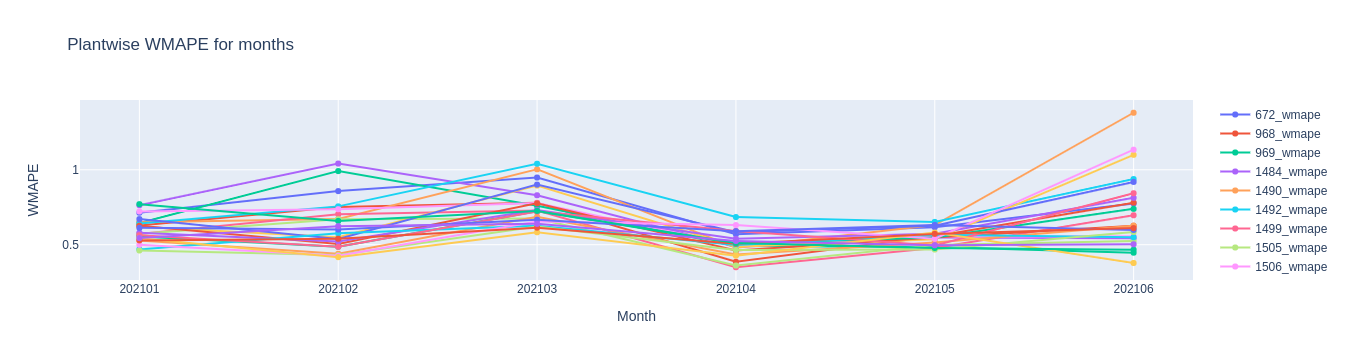

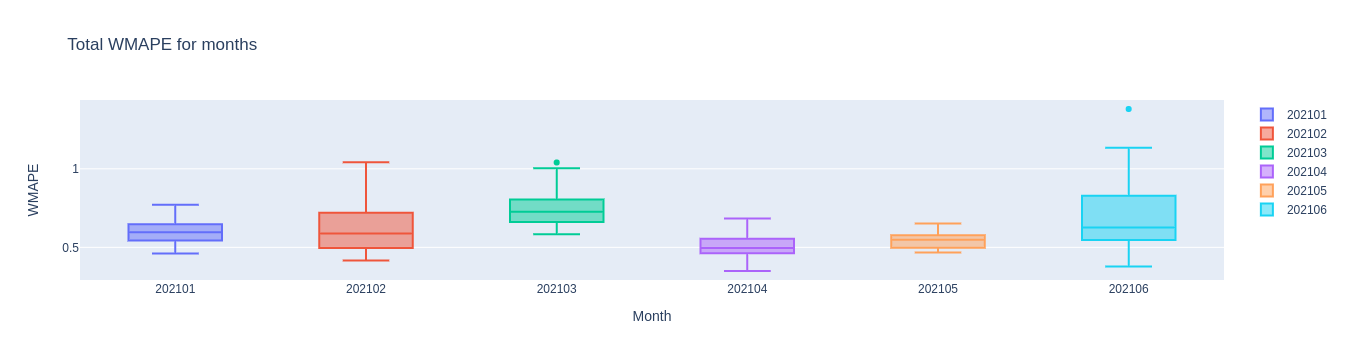

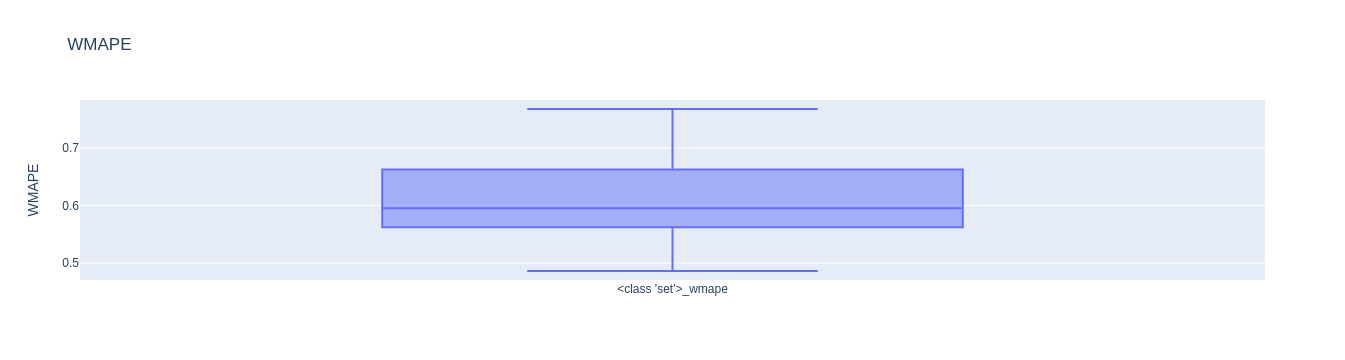

In [39]:
linear2.plot_accuracy(wmape_month_df, wmape_df)

In [56]:
CONV_WIDTH = 5

class Conv4(BaseTFModel):
    def __init__(self, window):
        super().__init__(window)

    def add_model(self, model):
        model.add(layers.Permute((2,1,3)))
        model.add(layers.Conv2D(64, CONV_WIDTH, activation="relu", padding="same"))
        model.add(layers.Permute((2,3,1)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Permute((3,1,2)))
        model.add(layers.Conv2D(32, CONV_WIDTH, activation="relu", padding="same"))
        model.add(layers.Permute((2,3,1)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Permute((3,1,2)))
        return model
    
conv = Conv4(window)
# conv.start_wandb()

In [57]:
conv.compile_and_fit(**config["compiler"])

2022-05-06 12:35:45.713223: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
107/231 [============>.................] - ETA: 1:00 - loss: 0.0734 - wmape: 0.5932

KeyboardInterrupt: 

In [ ]:
conv.plot("test")

In [57]:
len(conv.window.data.train_indices)

23714

2568 2568 2609
2568 2568 2609
2568 2568 2609
2568 2568 2609
2568 2568 2609
2568 2568 2609
2568 2568 2609
2568 2568 2609
2568 2568 2609
2568 2568 2609


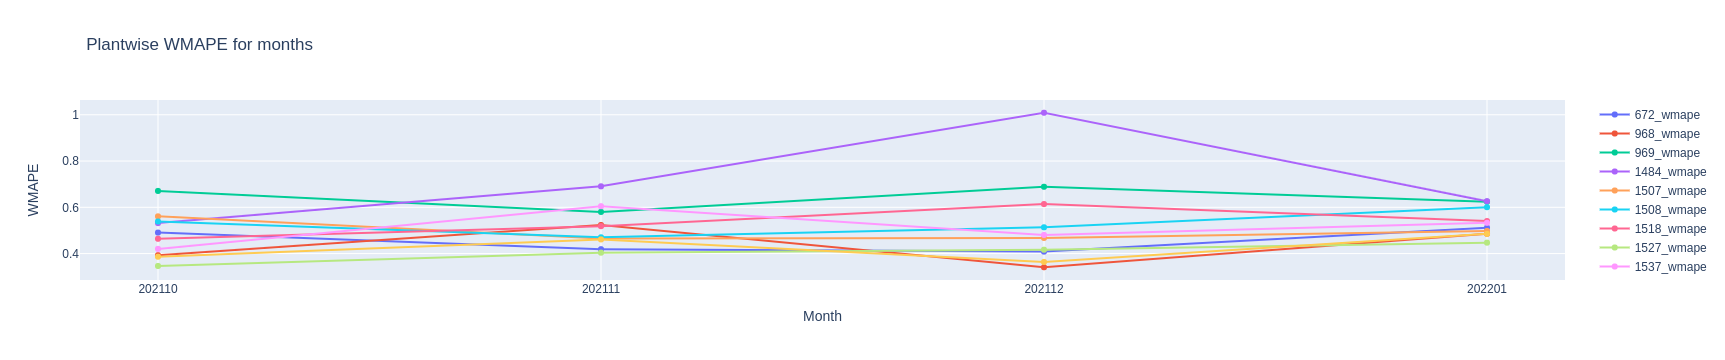

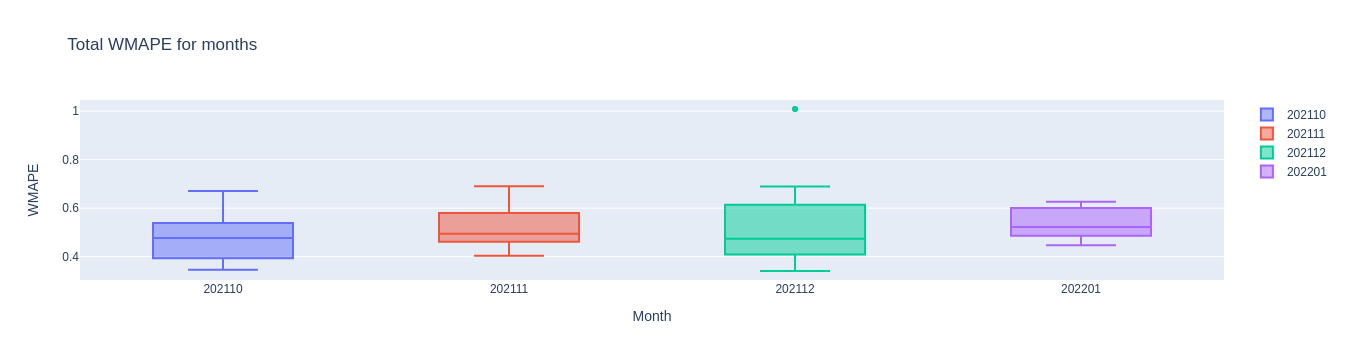

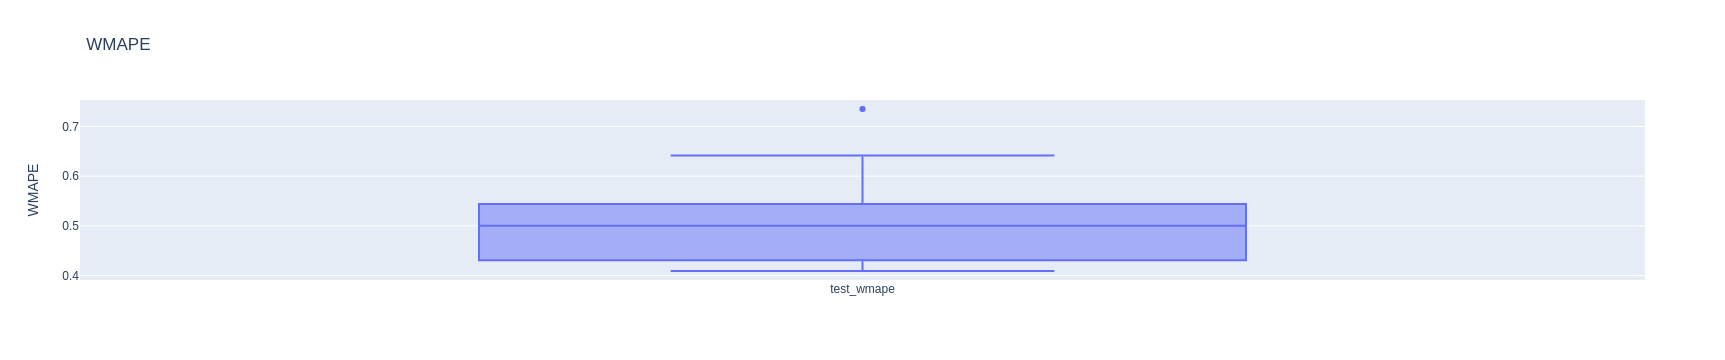

In [61]:
conv.plot_accuracy("test")

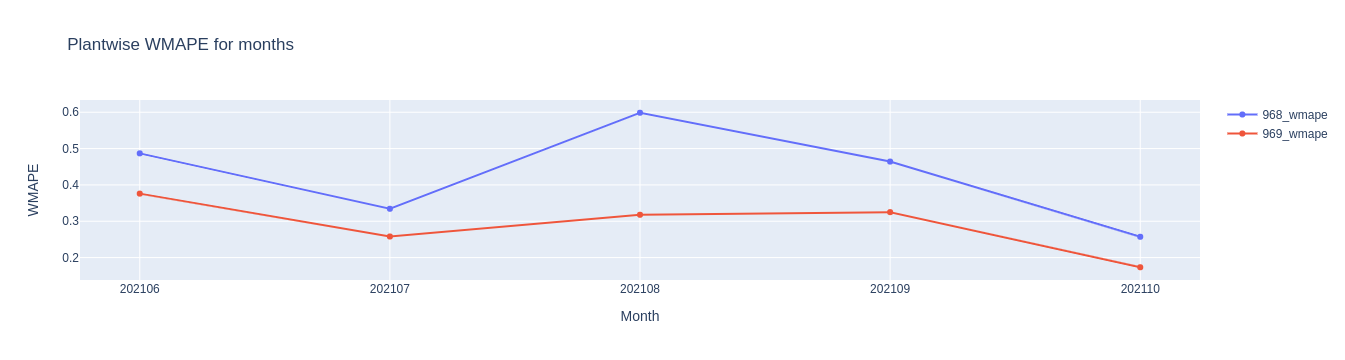

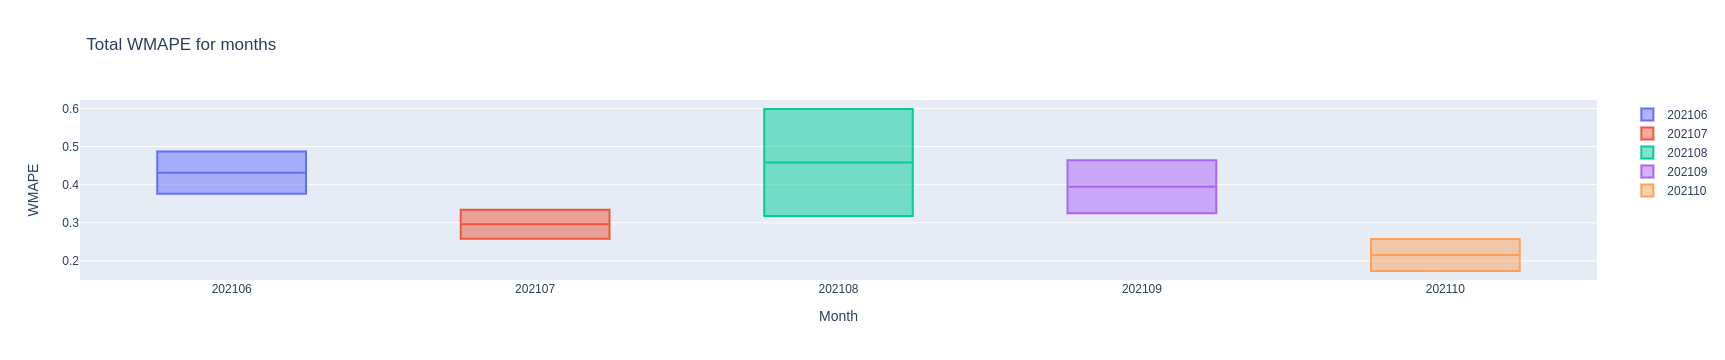

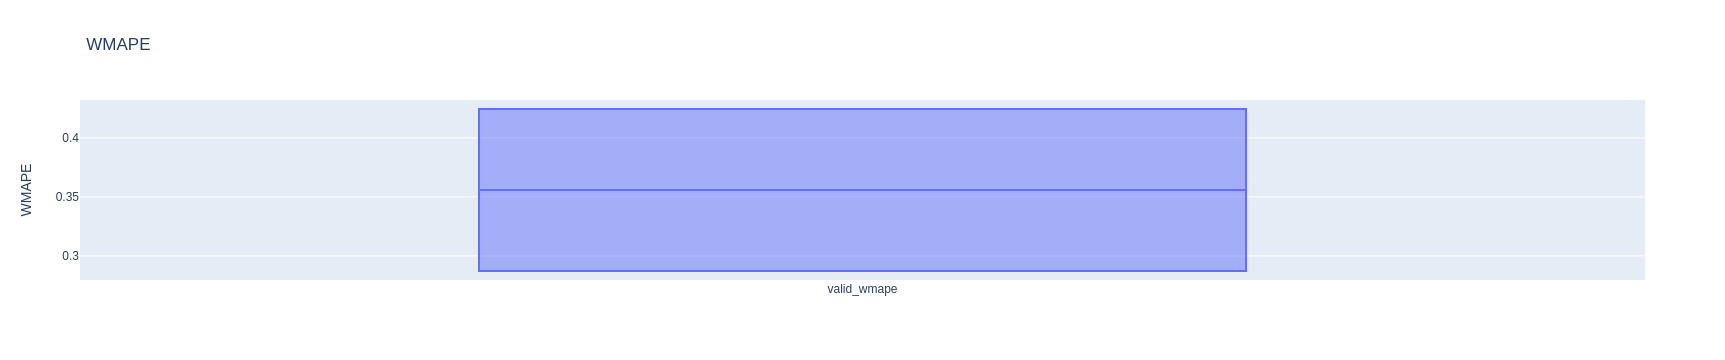

In [12]:
linear2.plot_accuracy("valid")

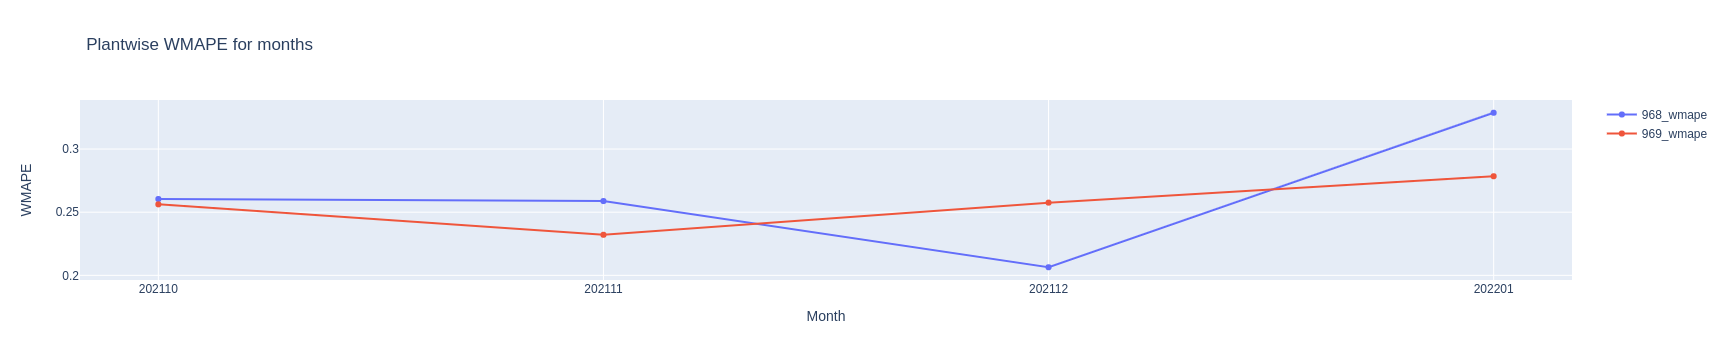

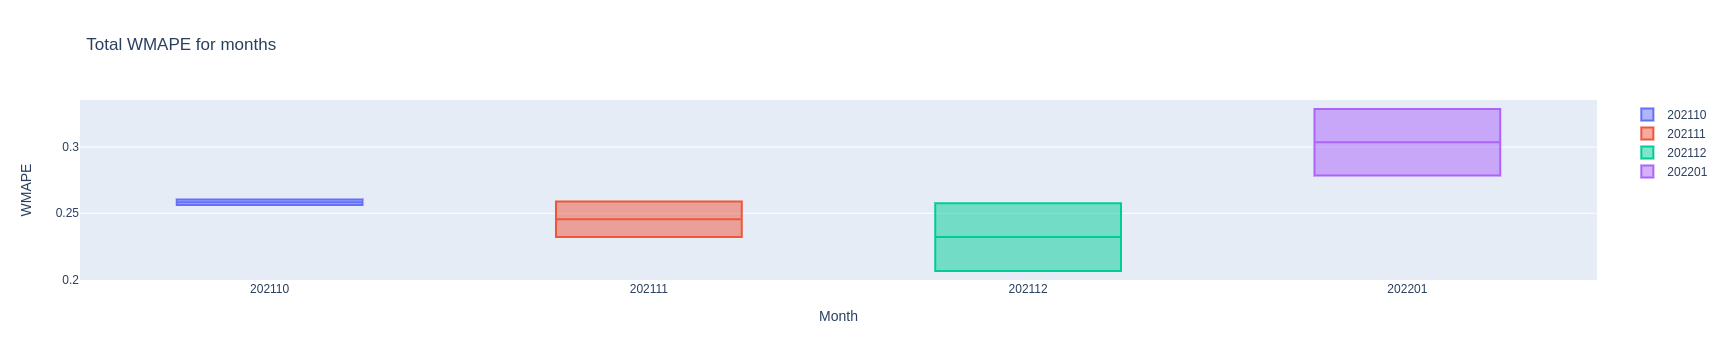

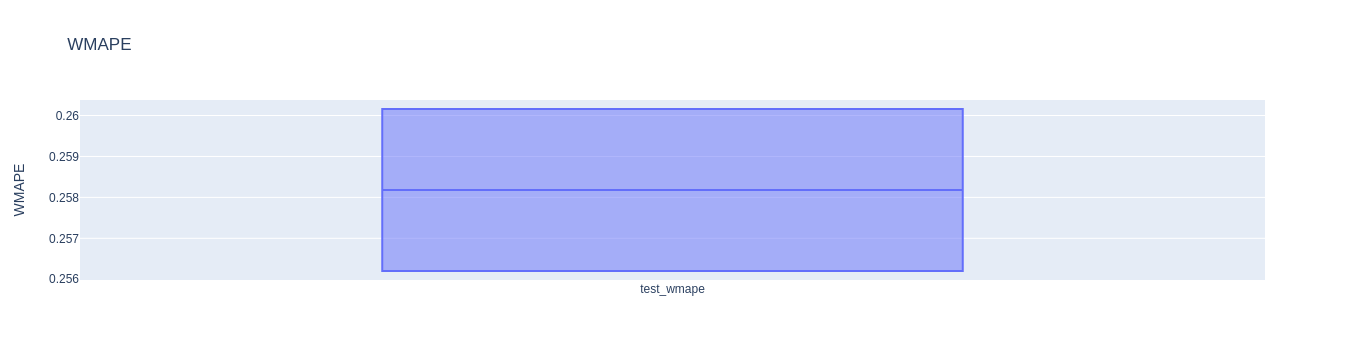

In [19]:
conv.plot_accuracy("test")

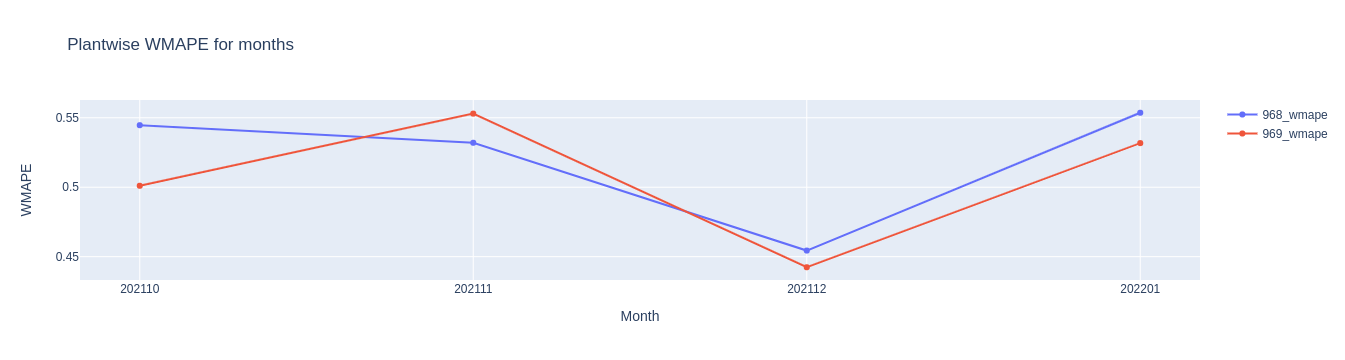

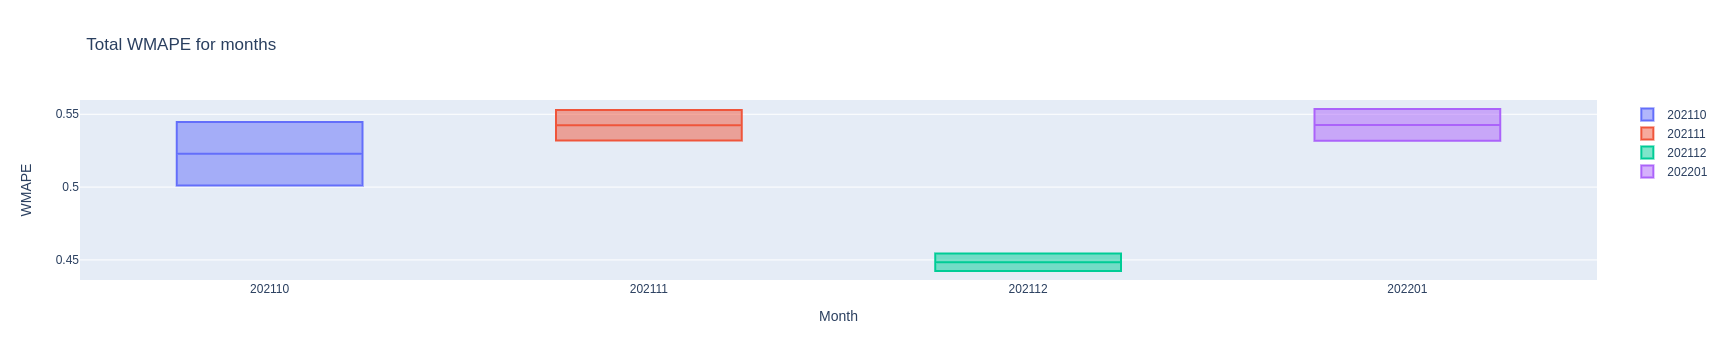

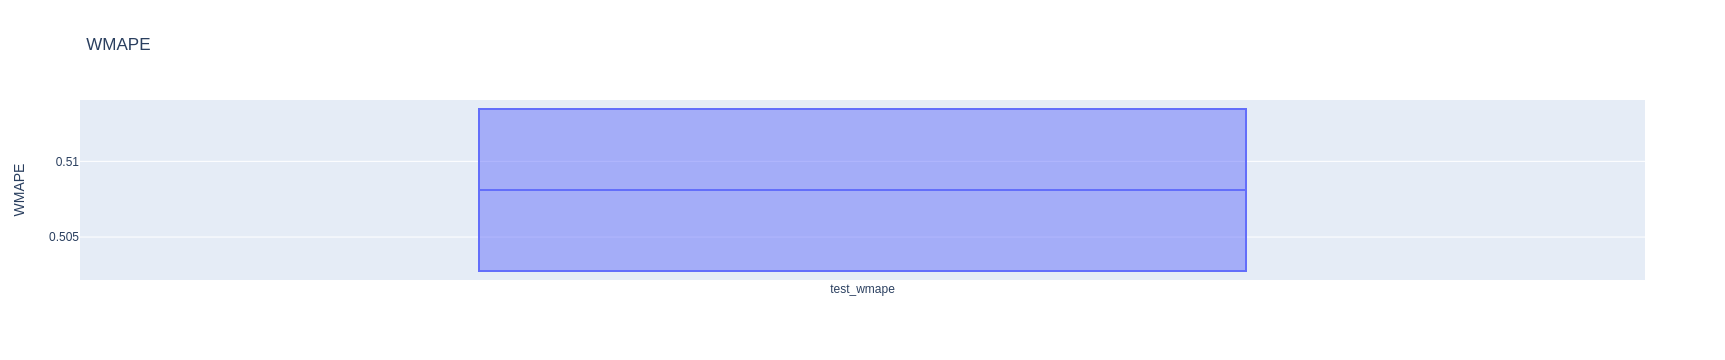

In [13]:
linear2.plot_accuracy("test")

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
predictions_val = linear2.fitted_model.predict(linear2.window.valid)
actuals_val = np.concatenate([y for _, y in linear2.window.valid], axis=0)


In [ ]:
i, j = 0, 672

In [ ]:
self = linear2
def _calculate_wmape(pred, actual):
    return np.sum(np.abs(actual - pred)) / np.sum(actual)

In [ ]:
predictions = self.fitted_model.predict(self.window.test)
actuals = np.concatenate([y for _, y in self.window.test], axis=0)

wmape_month_df = pd.DataFrame()
wmape_df = pd.DataFrame()

for i, plant in enumerate(self.window.data.plants):
    actual_ = actuals[:, :, i].reshape(-1)
    pred_ = predictions[:, :, i].reshape(-1)

    temp_df = pd.DataFrame({ 
        "rt_plant_id": plant,
        "month": pd.to_datetime(linear2.window.data.test_indices[-len(actual_):]).strftime("%Y%m"),
        "actual": actual_,
        "pred": pred_,
    })
    wmape_month_ = temp_df.groupby(["month", "rt_plant_id"], as_index=False).apply(lambda x: pd.Series({"wmape": _calculate_wmape(x["pred"], x["actual"])}))
    wmape_ = temp_df.groupby(["rt_plant_id"], as_index=False).apply(lambda x: pd.Series({"wmape": _calculate_wmape(x["pred"], x["actual"])}))

    wmape_month_df = wmape_month_df.append(wmape_month_)
    wmape_df = wmape_df.append(wmape_)


In [ ]:
wmape_df

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
# from utils.base_helpers import read_data, split_data, scale_data, expand_data, plot_metrics
from utils.tf_helpers import WindowGenerator, compile_and_fit, calculate_plantwise_wmape, plot_plantwise_predictions


In [ ]:
df, plants = read_data(generate_speed_angle=True, add_lagged=True, number_of_plants=24)
train_df_, valid_df_, test_df_ = split_data(df, train_ratio=0.8, valid_ratio=0.1)
train_df, valid_df, test_df = expand_data(train_df_, valid_df_, test_df_)
train_df, valid_df, test_df = scale_data(train_df, valid_df, test_df, plants, scaler="minmax")

# Dense

In [ ]:
config={
    # "architecture": {
    #     "dense": {"dense_units": 24, "kernel_initializer": "zeros"},
    #     "dropout": {"rate": 0.2}, 
    # },
    "dataset": {
        "label_width": 24,
        "input_width": 48,
        "shift": -12,
    },
    "epochs": 50,
    "optimizer": "adam",
    "loss": "mse",
}

In [ ]:
data.tra

In [ ]:
window = WindowGenerator(
    train_df=data.train_df, valid_df=data.valid_df, test_df=data.test_df, 
    columns=[col for col in data.df.columns if col != "rt_plant_id"],
    label_columns=["production"], **config["dataset"])
window

In [ ]:
from abc import abstractmethod
from unicodedata import name
from tensorflow.keras import models, layers
import tensorflow as tf
from datetime import datetime

class BaseTFModel:
    def __init__(self, window):
        self.window = window

    @property
    def model(self):
        model = models.Sequential()
        model.add(layers.InputLayer(input_shape=(self.window.input_shape)))
        model.add(layers.Permute((1,2,3), name="start------"))

        model = self.add_model(model)

        model.add(layers.Reshape([self.window.number_of_plants, -1], name="end--------"))
        model.add(layers.Dense(self.window.label_width))
        model.add(layers.Permute((2,1)))
        model.add(layers.Reshape([self.window.label_width, self.window.number_of_plants, 1]))
        return model

    @abstractmethod
    def add_model(self, model):
        return model

    def __repr__(self):
        return self.__class__.__name__
    
    def start_wandb(self, project="keras", name=None, config=None):
        name = name or self.__class__.__name__ + "_" + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        wandb.init(project="keras", name=name, config=config)



## Linear2

In [ ]:
class Linear2(BaseTFModel):
    def __init__(self, window):
        super().__init__(window)

    def add_model(self, model):
        model.add(layers.Dense(24, kernel_initializer=tf.initializers.zeros()))
        model.add(layers.Dropout(0.2))
        return model
    
linear2 = Linear2(window)
# linear2.start_wandb()

In [ ]:
linear2.model.summary()

In [ ]:
window.__getattribute__("train")

In [ ]:
model, history = compile_and_fit(linear2.model, window, verbose=2, epochs=config["epochs"], loss=config["loss"], optimizer=config["optimizer"])

In [ ]:
wmape_df = calculate_plantwise_wmape(model, window, selected_plants=df.rt_plant_id.unique()) # puts wandb

In [ ]:
import numpy as np
import plotly.graph_objects as go

In [ ]:
window.

In [ ]:
plot_plotly(window.valid, data.plants, data.valid_indices, log_name="valid_predictions")

In [ ]:
plot_plotly(window.test, plants, test_df_.index.unique(), log_name="test_predictions")

In [ ]:
wandb.finish()

In [ ]:
data

In [ ]:
# !pip install plotly-express jupyter-dash

In [ ]:
run = wandb.init(project="keras", job_type='evaluate')

In [ ]:
artifact = run.use_artifact('run-3ush2u6h-wmape_table:v0')

In [ ]:
artifact_dir = artifact.download()

In [ ]:
import pandas as pd
pd.read_json(artifact_dir)

In [ ]:
model, history = compile_and_fit(model, window, verbose=2, epochs=config["epochs"], loss=config["loss"], optimizer=config["optimizer"])


In [ ]:
val_performance["-".join(param_dict.values())] = model.evaluate(window.valid)
performance["-".join(param_dict.values())] = model.evaluate(window.test)


In [ ]:
class Linear3(BaseTFModel):
    def __init__(self, window):
        super().__init__(window)

    def add_model(self, model):
        model.add(layers.Permute((2,1,3)))
        model.add(layers.Dense(16, kernel_initializer=tf.initializers.zeros()))
        model.add(layers.Dropout(0.2))
        return model
    
model = Linear3(window).model
model.summary()

In [ ]:
val_performance = {}
performance = {}

param_list = [
    {"loss": "mse", "optimizer": "rmsprop"},
    {"loss": "mse", "optimizer": "adam"},
]

for param_dict in param_list:
    model, history = compile_and_fit(model, window, max_epochs=10, verbose=2, **param_dict)
    val_performance["-".join(param_dict.values())] = model.evaluate(window.valid)
    performance["-".join(param_dict.values())] = model.evaluate(window.test)


# CNN

## Conv4

In [ ]:
CONV_WIDTH = 5

class Conv4(BaseTFModel):
    def __init__(self, window):
        super().__init__(window)

    def add_model(self, model):
        model.add(layers.Permute((2,1,3)))
        model.add(layers.Conv2D(64, CONV_WIDTH, activation="relu", padding="same"))
        model.add(layers.Permute((2,3,1)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Permute((3,1,2)))
        model.add(layers.Conv2D(32, CONV_WIDTH, activation="relu", padding="same"))
        model.add(layers.Permute((2,3,1)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Permute((3,1,2)))
        return model
    
model = Conv4(window).model
model.summary()

In [ ]:
model, history = compile_and_fit(model, window, max_epochs=10, verbose=1, loss="mse", optimizer="adam")
val_performance["CNN"] = model.evaluate(window.valid)
performance["CNN"] = model.evaluate(window.test)

In [ ]:
plot_metrics(performance, val_performance)

In [ ]:
wmape_df = calculate_plantwise_wmape(model, window, selected_plants=df.rt_plant_id.unique())
wmape_df

In [ ]:
plot_plantwise_predictions(model, window.test)

In [ ]:
plot_plantwise_predictions(model, window.valid)

# Recurrent

## RNN3

In [ ]:
class RNN3(BaseTFModel):
    def __init__(self, window):
        super().__init__(window)

    def add_model(self, model):
        model.add(layers.Permute((2,1,3)))
        model.add(layers.Reshape((self.window.number_of_plants, -1)))
        model.add(layers.Permute((2,1)))
        model.add(layers.MaxPooling1D(2))
        model.add(layers.Permute((2,1)))
        model.add(layers.LSTM(32, return_sequences=True))
        model.add(layers.LSTM(24, return_sequences=True))
        return model
    
model = RNN3(window).model
model.summary()

In [ ]:
history = compile_and_fit(model, window, max_epochs=10, verbose=1, loss="mse", optimizer="adam")

In [ ]:
val_performance['RNN3'] = model.evaluate(window.valid)
performance['RNN3'] = model.evaluate(window.test)
